# 0 - Imports

In [1]:
from google.colab import drive
import os, glob
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from glob import glob
from skimage.metrics import structural_similarity as ssim
import cv2

In [2]:
!git clone https://github.com/MathieuRita/SAR_denoising.git
%cd SAR_denoising


Cloning into 'SAR_denoising'...
remote: Enumerating objects: 438, done.
remote: Counting objects: 100% (18/18), done.
remote: Compressing objects: 100% (16/16), done.
remote: Total 438 (delta 6), reused 5 (delta 2), pack-reused 420 (from 1)
Receiving objects: 100% (438/438), 161.58 MiB | 36.01 MiB/s, done.
Resolving deltas: 100% (126/126), done.
/content/SAR_denoising


In [3]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [4]:
!unzip "/content/drive/My Drive/FFDNet_datasets_png_npy.zip" -d "/content/"


Archive:  /content/drive/My Drive/FFDNet_datasets_png_npy.zip
  inflating: /content/FFDNet_data/train/0000098.npy  
  inflating: /content/FFDNet_data/train/0000617 - Copy.npy  
  inflating: /content/FFDNet_data/train/0000063.npy  
  inflating: /content/FFDNet_data/train/0000427.npy  
  inflating: /content/FFDNet_data/train/0000376.npy  
  inflating: /content/FFDNet_data/train/0000398.npy  
  inflating: /content/FFDNet_data/train/0039131.npy  
  inflating: /content/FFDNet_data/train/0001456.npy  
  inflating: /content/FFDNet_data/train/0000007.npy  
  inflating: /content/FFDNet_data/train/0000499.npy  
  inflating: /content/FFDNet_data/train/0000454.npy  
  inflating: /content/FFDNet_data/train/0039115.npy  
  inflating: /content/FFDNet_data/train/0000211.npy  
  inflating: /content/FFDNet_data/train/0000115.npy  
  inflating: /content/FFDNet_data/train/0000097.npy  
  inflating: /content/FFDNet_data/train/0039130.npy  
  inflating: /content/FFDNet_data/train/0000217.npy  
  inflating: 

In [5]:
import os

path_to_test = "/content/FFDNet_data/test"
print(os.listdir(path_to_test)[:10])  # Show first 10 files


['0002929.png', '0115711.npy', '0003228.npy', '0116403.npy', '0002927.png', '0116297.png', '0116072.png', '0109659.png', '0115711.png', '0116374.npy']


In [6]:
dataset_path = "/content/FFDNet_datasets_png_npy"


In [7]:
import os
import numpy as np

path_to_Train = '/content/FFDNet_data/train'
path_to_Test = '/content/FFDNet_data/test'


# 0 -Extract the data

In [8]:
path_to_Train = '/content/FFDNet_data/train'
path_to_Test = '/content/FFDNet_data/test'
files_train = os.listdir(path_to_Train)
files_test = os.listdir(path_to_Test)

train_list=[]
test_list=[]

for file in files_train:
  if '.npy' in file:
    train_list.append(np.load(path_to_Train+str("/")+file))

for file in files_test:
  if '.npy' in file:
    test_list.append(np.load(path_to_Test+str("/")+file))

# I - Create the dataset & preprocessing

In this part, we build the dataset of noisy/denoised images and provide useful functions to plot the images:

## Create the training and testing datasets.

Take the train/test images and segment them into images of size `img_size` (default value **128**). Then store them into `X_train`/`X_test`.

Segment the images to get two sets:

- `X_train`: `shape=(n_training_samples,img_size,img_size)`
- `X_test`: `shape=(n_testing_samples,img_size,img_size)`

In [9]:
img_size=128

X_train=np.zeros((1,img_size,img_size))

for train_image in train_list:

  for i in range(int(train_image.shape[0]/img_size)):
    for j in range(int(train_image.shape[1]/img_size)):
      im_to_add=np.expand_dims(train_image[i*img_size:(i+1)*img_size,j*img_size:(j+1)*img_size],axis=0)
      X_train=np.concatenate((X_train,im_to_add),axis=0)

X_train=X_train[1:,:,:]

print("Shape of the training set is: ",X_train.shape)

Shape of the training set is:  (568, 128, 128)


In [10]:
img_size=384

X_test=np.zeros((1,img_size,img_size))

for test_image in test_list:

  for i in range(int(test_image.shape[0]/img_size)):
    for j in range(int(test_image.shape[1]/img_size)):
      im_to_add=np.expand_dims(test_image[i*img_size:(i+1)*img_size,j*img_size:(j+1)*img_size],axis=0)
      X_test=np.concatenate((X_test,im_to_add),axis=0)

X_test=X_test[1:,:,:]

print("Shape of the training set is: ",X_test.shape)

Shape of the training set is:  (47, 384, 384)


## Addition of noise

**Reference**

To see the references on how to sample speckle noise, please refer to: https://arxiv.org/pdf/1704.05335.pdf.

______________________________

**Notations**

Here we note $I=R \times S$ with:
- $I$: noisy image (intensity)
- $R$: true image without noise (reflectivity)
- $S$: speckle noise

$I$ is assumed to follow the following distribution:

$p_{I}(I|R)=\frac{L^{L}I^{L-1}}{\Gamma(L)R^{L}}exp(-L\frac{I}{R})$ (where L is the number of views)
_______________________________

**Description of the code**

We preprocess each data as follows:

- We normalize the data according to the general statistics of the images (max and min of all images)
- Then, we add speckle for all images and create pairs of clear/noisy images

After this step, we have a couple of noisy/denoised image stored in:

- `X_train`: `shape=(2,n_training_samples,img_size,img_size)`
- `X_test`: `shape=(2,n_testing_samples,img_size,img_size)`

In [11]:
"""
Normalization
1- Function to normalize the data
2- Application to the training and testing sets
"""

def normalize_SAR(dim,log=False):

  # Normalization parameters
  M = 10.089038980848645
  m = -1.429329123112601

  if log:
    dim = ((np.log(dim)-m)*255 / (M - m))
  else:
    dim = (dim-np.exp(m))*255 / (np.exp(M) - np.exp(m))

  return dim

## Training set
for i in range(X_train.shape[0]):
  X_train[i]=normalize_SAR(X_train[i])

## Testing set
for i in range(X_test.shape[0]):
  X_test[i]=normalize_SAR(X_test[i])

In [12]:
"""
Speckle addition
1- Function to add spekle (multiplication in amplitude)
2- Application to  the two sets
"""

# Noise function
def injectspeckle_amplitude(imgs,L,sing_im=False):

  if sing_im:
      rows = imgs.shape[0]
      columns = imgs.shape[1]
      s = np.zeros((rows, columns))
      for k in range(0,L):
          gamma = np.abs( np.random.randn(rows,columns) + np.random.randn(rows,columns)*1j )**2/2
          s = s + gamma
      s_amplitude = np.sqrt(s/L)
      ima_speckle_amplitude = np.multiply(imgs,s_amplitude)

  if not sing_im:
      n_imgs=imgs.shape[0]
      rows = imgs.shape[1]
      columns = imgs.shape[2]
      s = np.zeros((n_imgs,rows, columns))
      for k in range(0,L):
          gamma = np.abs( np.random.randn(n_imgs,rows,columns) + np.random.randn(n_imgs,rows,columns)*1j )**2/2
          s = s + gamma
      s_amplitude = np.sqrt(s/L)
      ima_speckle_amplitude = np.multiply(imgs,s_amplitude)

  return ima_speckle_amplitude

# Number of views (typically L=1-2 small values)
L=1

# Create the array of couples by duplicating the samples
X_train_couples=np.tile(X_train,(2,1,1,1))
X_test_couples=np.tile(X_test,(2,1,1,1))

# Addition of noise
X_train_couples[1,:,:,:]=injectspeckle_amplitude(X_train_couples[1,:,:,:],L=L)
X_test_couples[1,:,:,:]=injectspeckle_amplitude(X_test_couples[1,:,:,:],L=L)

print("Shape of the training couples", X_train_couples.shape)
print("Shape of the testing couples", X_test_couples.shape)

Shape of the training couples (2, 568, 128, 128)
Shape of the testing couples (2, 47, 384, 384)


## Visualize and save the denoised/noisy images

We provide example functions to plot and save SAR images that takes as input a numpy array. These functions will be used in all the notebook. Indeed, this implementation of FFDNet works taking raw images as input. Therefore, we have to save the SAR images that will be use during the training in a directory.

True image


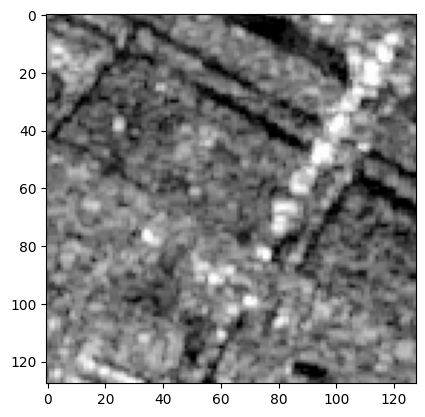

Noisy image


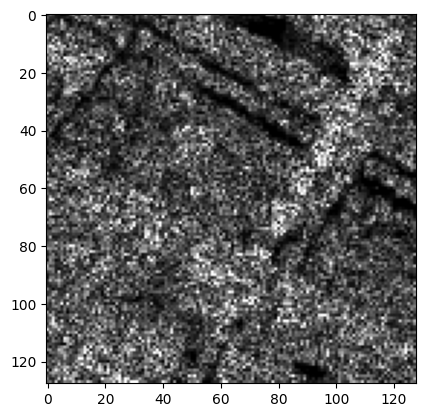

True image


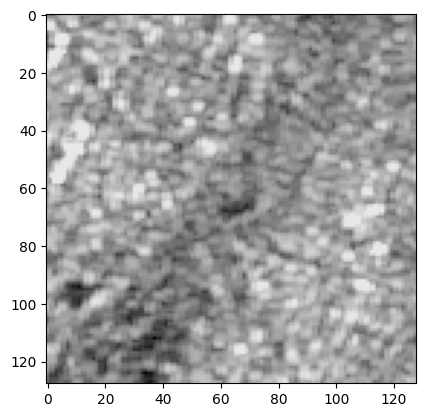

Noisy image


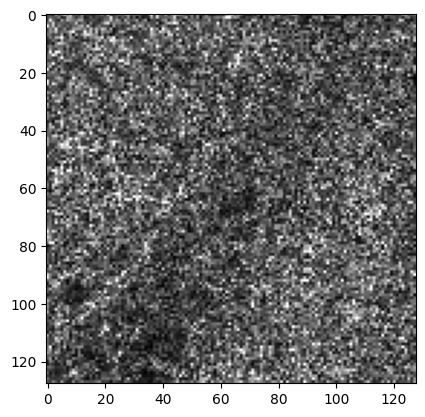

True image


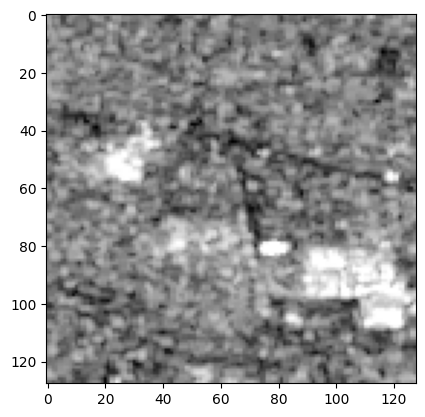

Noisy image


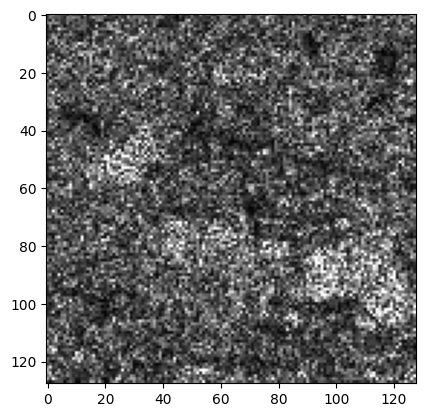

In [13]:
"""
Plot function
1- Plot function
2- Choose some images and plot the pair true image / noisy image
"""

def plot_SAR(np_array,log=False):

  # Normalization parameters
  M = 10.089038980848645
  m = -1.429329123112601
  dim = np_array
  dim = np.squeeze(dim)
  threshold=np.mean(dim) + 3*np.std(dim)
  dim = np.clip(dim,0,threshold)
  dim = dim/threshold*255
  dim = Image.fromarray(dim.astype('float64')).convert('L')
  plt.imshow(dim,cmap="gray",vmin=0,vmax=255)
  plt.show()

for i in [1,12,25]:
  print("True image")
  plot_SAR(X_train_couples[0,i,:,:])
  print("Noisy image")
  plot_SAR(X_train_couples[1,i,:,:])

Now let's introduce a function that allows to save the images and create the directories that will be used for the train.

In [14]:
"""
Save images
1- Function to save the SAR images
2- Create a training (clear images) and testing set (noisy images)
"""

def save_SAR(np_array,name,add_speckle=False):

  # Normalization parameters
  M = 10.089038980848645
  m = -1.429329123112601

  # Thres + log
  dim = np_array
  dim = np.squeeze(dim)
  threshold=np.mean(dim) + 3*np.std(dim)
  dim = np.clip(dim,0,threshold)
  dim = dim/threshold*255
  if add_speckle:
    dim=injectspeckle_amplitude(dim,L=1,sing_im=True)
  dim = Image.fromarray(dim.astype('float64')).convert('L')
  dim.save(name)

# Training set (denoised images)
! rm -rf trainsets
! mkdir trainsets
! mkdir trainsets/trainH
for i in range(X_train_couples.shape[1]):
  name="trainsets/trainH/im"+str(i)+".bmp"
  save_SAR(X_train_couples[0,i,:,:],name=name)

# Testing set (noisy images)
! rm -rf testsets
! mkdir testsets
! mkdir testsets/bsd68
for i in range(X_test_couples.shape[1]):
  name="testsets/bsd68/im"+str(i)+".bmp"
  save_SAR(X_test_couples[0,i,:,:],name=name)


# II - FFDNet

In this section, we are going to train FFDNet with the set of images previously saved. To do so, you first have to load in Colab the github repository with FFDNet. Then, we introduce two subsections:

- **Train FFDNet**: Train FFDNet

- **Test FFDNet**: Apply FFDNet on a set of testing images

In [15]:
# Clear the working space
! rm -rf MVA_Remote
! rm -rf data
! rm -rf model_zoo
! rm -rf models
! rm -rf options
! rm -rf results
! rm -rf utils
! rm -rf main_train_ffdnet.py
! rm -rf main_test_ffdnet.py
! rm -rf denoising

# Git clone
! git clone https://github.com/MathieuRita/MVA_Remote.git

# Move the useful files in content
! mv "./MVA_Remote/data" "./data"
! mv "./MVA_Remote/model_zoo" "./model_zoo"
! mv "./MVA_Remote/models" "./models"
! mv "./MVA_Remote/options" "./options"
! mv "./MVA_Remote/results" "./results"
! mv "./MVA_Remote/utils" "./utils"
! mv "./MVA_Remote/main_train_ffdnet.py" "./main_train_ffdnet.py"
! mv "./MVA_Remote/main_test_ffdnet.py" "./main_test_ffdnet.py"
! mv "./MVA_Remote/main_test_ffdnet_LM.py" "./main_test_ffdnet_LM.py"
! mv "./MVA_Remote/main_test_ffdnet_oracle.py" "./main_test_ffdnet_oracle.py"
! rm -rf MVA_Remote

# Create useful directories for training procedure
! mkdir "denoising"
! mkdir "denoising/ffdnet"
! mkdir "denoising/ffdnet/images"
! mkdir "denoising/ffdnet/models"
! mkdir "denoising/ffdnet/options"

Cloning into 'MVA_Remote'...
remote: Enumerating objects: 438, done.
remote: Counting objects: 100% (18/18), done.
remote: Compressing objects: 100% (16/16), done.
remote: Total 438 (delta 6), reused 5 (delta 2), pack-reused 420 (from 1)
Receiving objects: 100% (438/438), 161.58 MiB | 36.20 MiB/s, done.
Resolving deltas: 100% (126/126), done.


## 1 - Train FFDNet

How to set the training procedure:

**1) Training/testing data**

- The training images have to be saved in `trainsets/trainH`
- The testing images have to be saved in `testsets/bsd68`

**2) Add a pretrained model**

- If you want to add a pretrained model, you have to put it in the folder `denoising/ffdnet/models` and name it `XXXX_G` where `XXXX` is a number (example: `100000_G`). Then, the training pipeline automaticaly takes this file into account. In the directory `./model_zoo`, we give a set of pre-trained models that can be used: `ffdnet_gray.pth`: the pre-trained weights provided by FFDNet's team and `loss_L1_view_L1.pth`, `loss_L1_view_L5.pth`, `loss_L2_view_L1.pth` that are the models used for the study.

**3) Output of the models**

- Every 5000 iterations, a file with the weights is saved in `ffdnet/models/` named with the convention `(num_ite)_G`. If you put a pretrained models, it will be `(chosen_number + num_ite)_G`

**4) Deplace the models for testing**

- Once the training is over, you have to move the model file `XXXX_G.pth` in the directory `./model_zoo` where it will be used for the testing part.

In [ ]:
# For the training procedure, add clear testing images
# (noise is added during the training procedure)

! rm -rf testsets
! mkdir testsets
! mkdir testsets/bsd68
for i in range(X_test_couples.shape[1]):
  name="testsets/bsd68/im"+str(i)+".bmp"
  save_SAR(X_test_couples[0,i,:,:],name=name)

# Run the training procedure
! python -m main_train_ffdnet

export CUDA_VISIBLE_DEVICES=0
LogHandlers setup!
25-03-25 09:18:21.635 :   task: ffdnet
  model: plain2
  gpu_ids: [0]
  scale: 1
  n_channels: 1
  sigma: [0, 75]
  sigma_test: 25
  merge_bn: False
  merge_bn_startpoint: 400000
  path:[
    root: denoising
    pretrained_netG: None
    task: denoising/ffdnet
    log: denoising/ffdnet
    options: denoising/ffdnet/options
    models: denoising/ffdnet/models
    images: denoising/ffdnet/images
  ]
  datasets:[
    train:[
      name: train_dataset
      dataset_type: ffdnet
      dataroot_H: trainsets/trainH
      dataroot_L: None
      H_size: 64
      dataloader_shuffle: True
      dataloader_num_workers: 8
      dataloader_batch_size: 64
      phase: train
      scale: 1
      n_channels: 1
    ]
    test:[
      name: test_dataset
      dataset_type: ffdnet
      dataroot_H: testsets/bsd68
      dataroot_L: None
      phase: test
      scale: 1
      n_channels: 1
    ]
  ]
  netG:[
    net_type: ffdnet
    in_nc: 1
    out_nc: 1
   

## 2 - Test FFDNet

### 2.1 - Denoising

Now, let's test one of the models we trained. We propose here 3 types of denoising that correspond to the 3 approaches we tried:

- Simple denoising with **uniform noise map**
- Denoising with non-uniform noise map estimated with **Local Means**
- Denoising with non-unform noise map estimated with the **Oracle Method**

Each of these methods is associated with a given python file:

- **uniform noise map:** `main_test_ffdnet.py`
- **Local Means:** `main_test_ffdnet_LM.py`
- **Oracle Method:** `main_test_ffdnet_oracle.py`

You can choose the method you want by commenting/uncommenting the lines in the following cell. By default, the three methods are applied.

_____________________________

**Choose you own models and parameters:**

- by default, the 3 files use the models of the project: `loss_L1_view_L1.pth` for the uniform noise map, `loss_L1_view_L5.pth` for the LM method and Oracle method. You can choose another model by modifying the python files `main_test_ffdnet.py` at line 68.

- if you want to modify the value of the noise level, open the python file and change the value at line 66.

______________________________
**Rk:** the statistics (PSNR/SSIM) printed are not indicative. Indeed, they compare the output and input images, ie. the noisy and denoised images

In [ ]:
# Create the testing set with noisy images
! rm -rf testsets
! mkdir testsets
! mkdir testsets/bsd68
for i in range(X_test_couples.shape[1]):
  name="testsets/bsd68/im"+str(i)+".bmp"
  save_SAR(X_test_couples[0,i,:,:],name=name,add_speckle=True)

print("\n Denoised with the uniform noise map method \n")
# Denoising with uniform noise map
! python -m main_test_ffdnet

print("\n Denoised with the LM method \n")
# Denoising with Local Means
! python -m main_test_ffdnet_LM

print("\n Denoised with the Oracle method \n")
# Denoising with the Oracle Method
! python -m main_test_ffdnet_oracle


 Denoised with the uniform noise map method 

LogHandlers setup!
20-04-09 11:24:26.110 : Model path: model_zoo/loss_L1_view_L1.pth
20-04-09 11:24:26.110 : model_name:loss_L1_view_L1, model sigma:0, image sigma:0
20-04-09 11:24:26.110 : testsets/bsd68
20-04-09 11:24:26.163 : im0.bmp - PSNR: 16.94 dB; SSIM: 0.1702.
20-04-09 11:24:26.218 : im1.bmp - PSNR: 13.84 dB; SSIM: 0.1028.
20-04-09 11:24:26.265 : im2.bmp - PSNR: 11.93 dB; SSIM: 0.0666.
20-04-09 11:24:26.313 : im3.bmp - PSNR: 17.63 dB; SSIM: 0.2986.
20-04-09 11:24:26.358 : im4.bmp - PSNR: 14.00 dB; SSIM: 0.1056.
20-04-09 11:24:26.408 : im5.bmp - PSNR: 11.52 dB; SSIM: 0.0284.
20-04-09 11:24:26.454 : im6.bmp - PSNR: 11.79 dB; SSIM: 0.0586.
20-04-09 11:24:26.455 : Average PSNR/SSIM(RGB) - bsd68_loss_L1_view_L1 - PSNR: 13.95 dB; SSIM: 0.1187

 Denoised with the LM method 

LogHandlers setup!
20-04-09 11:24:31.458 : Model path: model_zoo/loss_L1_view_L5_LM.pth
20-04-09 11:24:31.458 : model_name:loss_L1_view_L5_LM, model sigma:30, image s

### 2.2 - Show the results

Here is the function that we will use to show the results. The function plot:
- the noisy image
- the true image
- the denoised image (available in `"results/bsd68_"+model_name+"/im"+str(ind_im)+".bmp"`)

In [ ]:
def plot_results(model_name,ind_im=0,real_name="no"):

  """
  Function that plots the results (noisy, true and denooised images)
  """

  if real_name=="no":
    print("\n Image "+str(ind_im)+" \n")
    print("Noisy")
    plot_SAR(X_test_couples[1,ind_im,:,:])
    print("True")
    plot_SAR(X_test_couples[0,ind_im,:,:])
    print("denoised")
    im = Image.open("results/bsd68_"+model_name+"/im"+str(ind_im)+".bmp")
    plt.imshow(np.array(im).astype(int),"gray",vmin=0,vmax=255)
    plt.show()
  else:
    print("\n"+ real_name+" \n")
    print("Noisy")
    if real_name!="terrasar":
      im = Image.open("testsets/bsd68/"+real_name+".bmp")
    else:
      im = Image.open("testsets/bsd68/"+real_name+".jpg")
    plt.imshow(np.array(im).astype(int),"gray",vmin=0,vmax=255)
    plt.show()

    print("Denoised")
    if real_name!="terrasar":
      im = Image.open("results/bsd68_"+model_name+"/"+real_name+".bmp")
    else:
      im = Image.open("results/bsd68_"+model_name+"/"+real_name+".jpg")

    plt.imshow(np.array(im).astype(int),"gray",vmin=0,vmax=255)
    plt.show()

Results with the Uniform Noise Map method


 Image 0 

Noisy


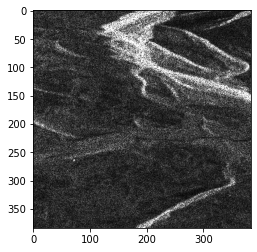

True


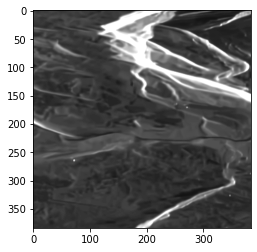

denoised


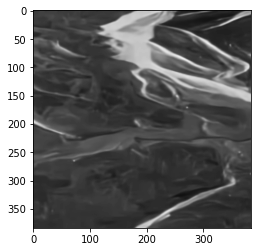


 Image 1 

Noisy


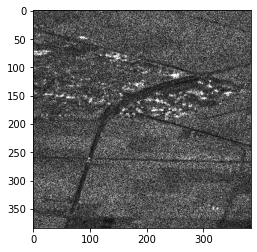

True


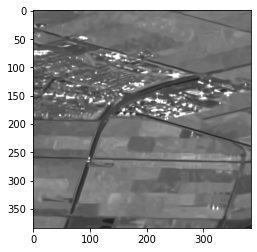

denoised


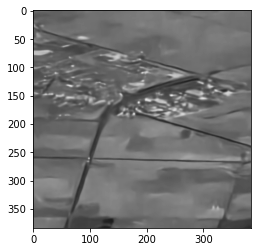


 Image 2 

Noisy


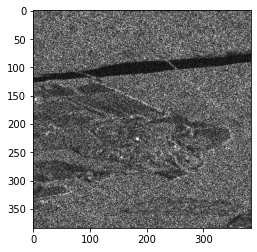

True


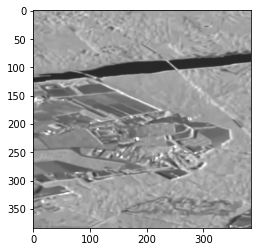

denoised


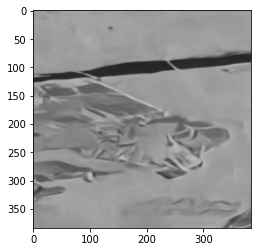


 Image 3 

Noisy


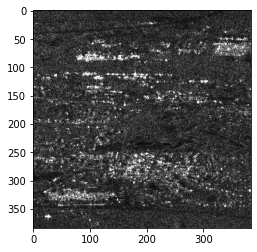

True


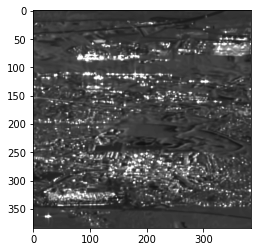

denoised


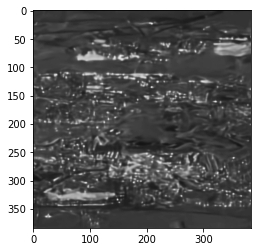


 Image 4 

Noisy


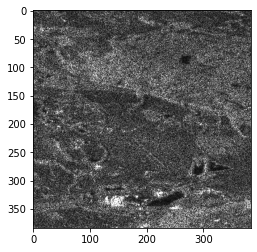

True


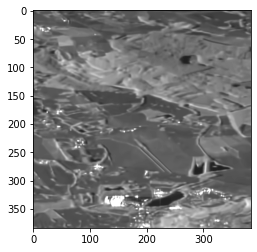

denoised


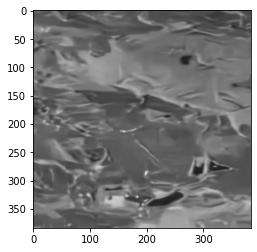


 Image 5 

Noisy


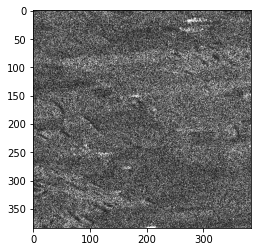

True


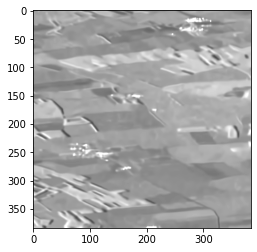

denoised


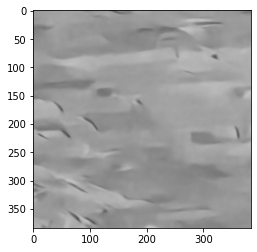


 Image 6 

Noisy


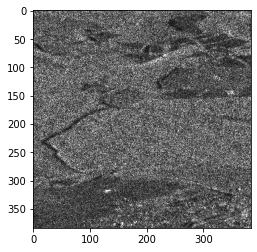

True


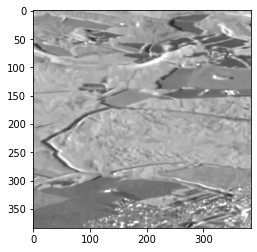

denoised


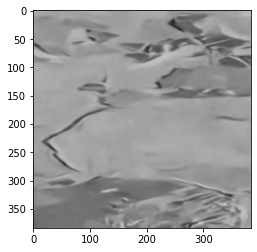

In [ ]:
model_name="loss_L1_view_L1"

for ind_im in range(7):
  plot_results(model_name,ind_im)

Results with the Local Means method


 Image 0 

Noisy


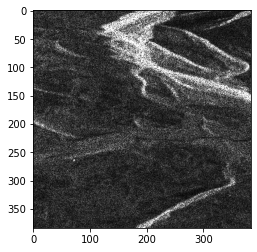

True


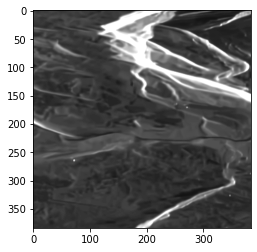

denoised


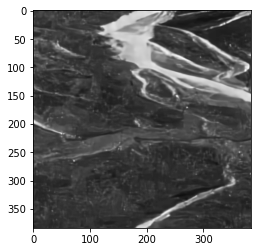


 Image 1 

Noisy


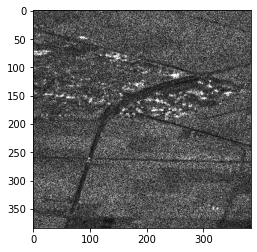

True


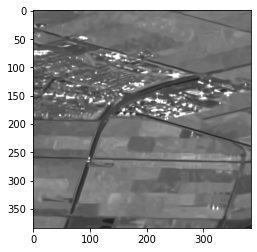

denoised


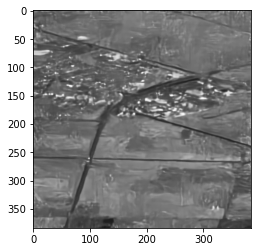


 Image 2 

Noisy


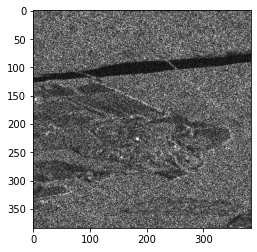

True


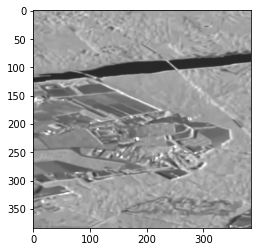

denoised


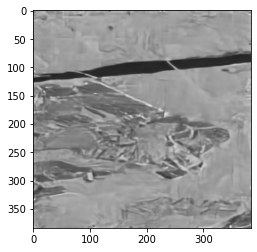


 Image 3 

Noisy


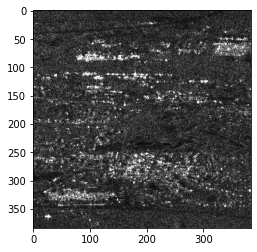

True


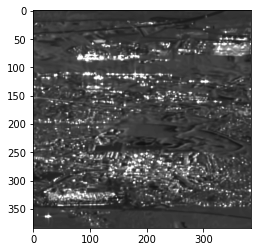

denoised


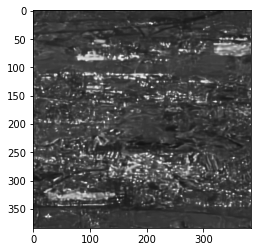


 Image 4 

Noisy


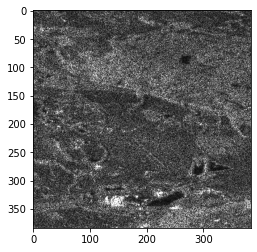

True


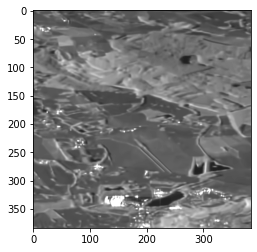

denoised


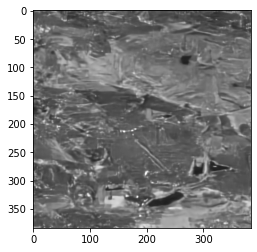


 Image 5 

Noisy


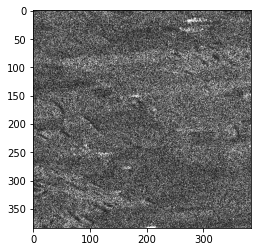

True


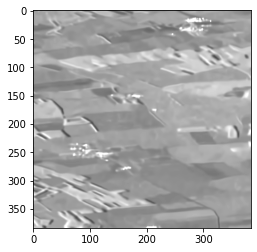

denoised


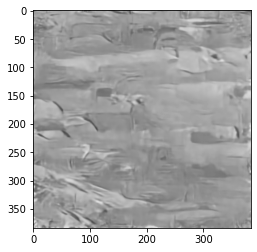


 Image 6 

Noisy


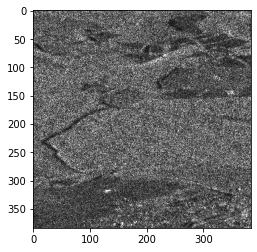

True


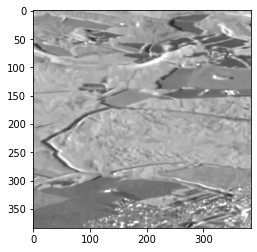

denoised


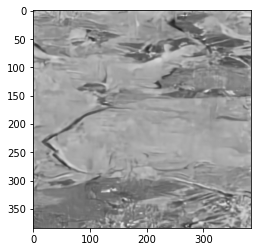

In [ ]:
model_name="loss_L1_view_L5_LM"

for ind_im in range(7):
  plot_results(model_name,ind_im)

Results with the Oracle method


 Image 0 

Noisy


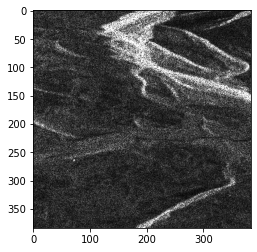

True


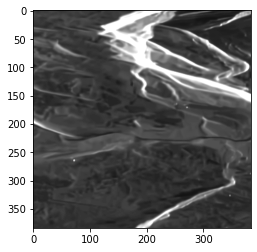

denoised


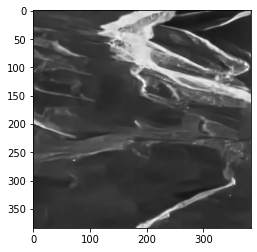


 Image 1 

Noisy


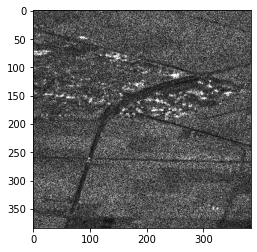

True


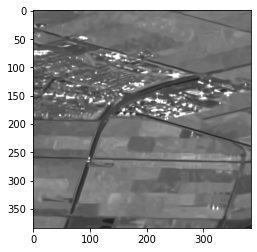

denoised


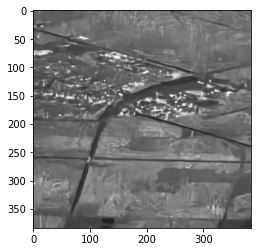


 Image 2 

Noisy


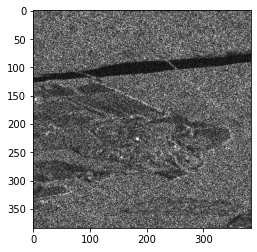

True


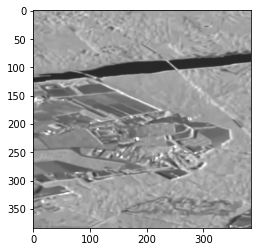

denoised


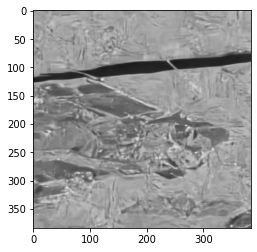


 Image 3 

Noisy


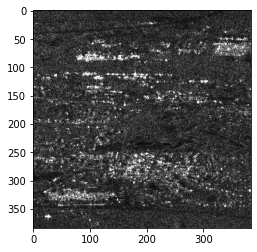

True


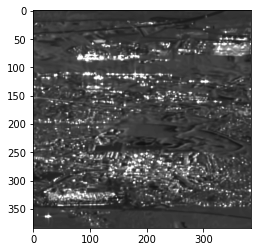

denoised


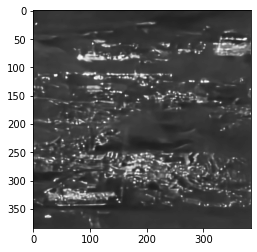


 Image 4 

Noisy


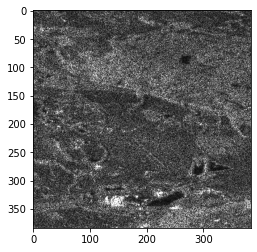

True


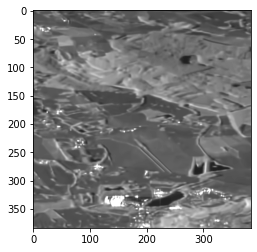

denoised


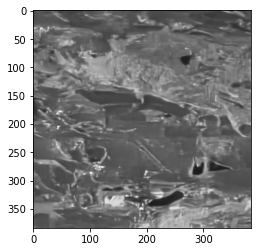


 Image 5 

Noisy


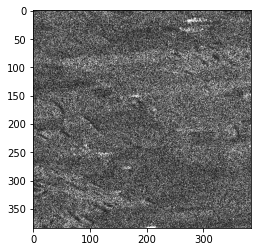

True


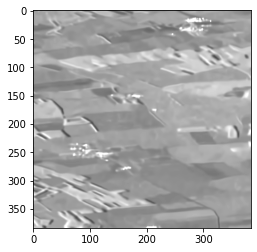

denoised


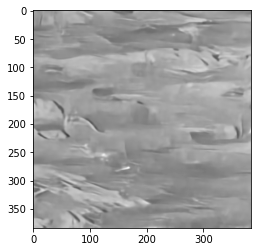


 Image 6 

Noisy


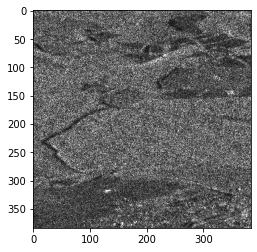

True


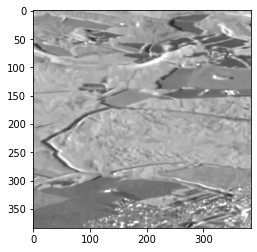

denoised


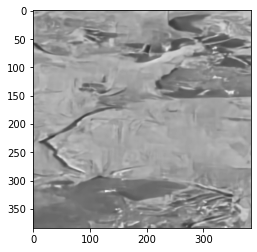

In [ ]:
model_name="loss_L1_view_L5"

for ind_im in range(7):
  plot_results(model_name,ind_im)

### 2.3 - Evaluation of the residual noise

We also propose a function that allows to verify that the statistics of the residual noise is correct. It plots the amplitude and intensity distribution of the noise:

In [ ]:
def method_noise(model_name,im_ind):

  """
  Plot the distribution of the residual noise in Amplitude / Intensity
  Print the statistics of the intensity residual noise
  """
  im = Image.open("results/bsd68_"+model_name+"/im"+str(im_ind)+".bmp")
  print("Mean")
  print(((np.array(Image.open("testsets/bsd68/im"+str(im_ind)+".bmp")).astype(int)/im)**2).mean())
  print("Var")
  print((((np.array(Image.open("testsets/bsd68/im"+str(im_ind)+".bmp")).astype(int))/im)**2).var())
  plt.hist(np.ravel(((np.array(Image.open("testsets/bsd68/im"+str(im_ind)+".bmp")).astype(int))/im)),bins=100,density=True,range=[0,3])  # Rayleigh distributed
  plt.title('histogram of amplitude')
  plt.show()
  plt.hist(np.ravel((np.array(Image.open("testsets/bsd68/im"+str(im_ind)+".bmp")).astype(int)/im)**2),bins=100,density=True,range=[0.,10.])  # Rayleigh distributed
  plt.title('histogram of intensity')
  plt.show()

Here is an example of application:

Examples with the uniform noise map method 

Im1
Mean
0.9772356114821513
Var
0.8173610932974543


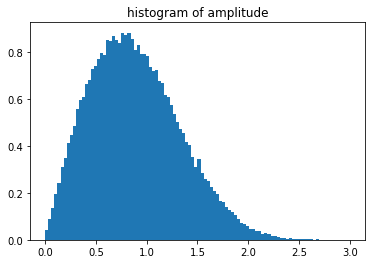

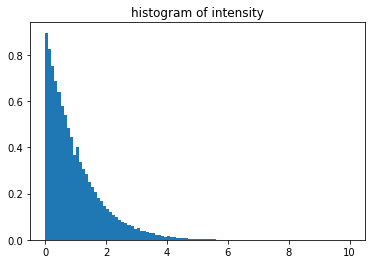

Im3
Mean
1.0784689500017546
Var
1.2226823617518896


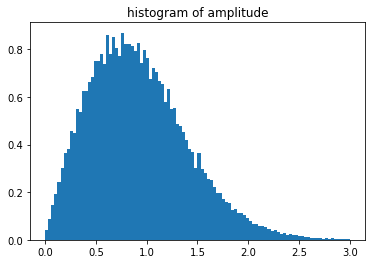

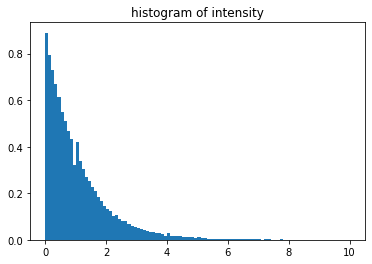

Im5
Mean
0.9926685115801965
Var
0.6814058768215667


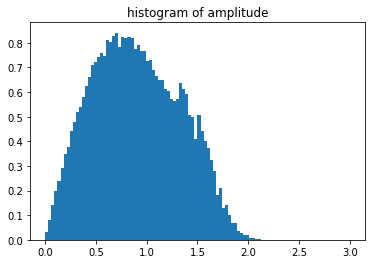

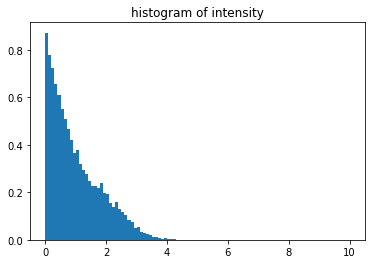

Examples with the Local Means method 

Im2
Mean
0.9660754518738235
Var
0.6637328665634672


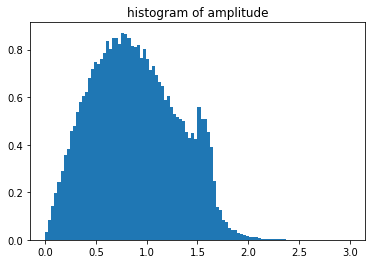

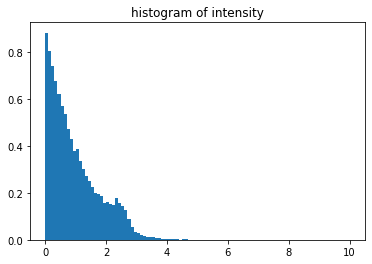

Im3
Mean
0.9589171302897643
Var
0.7358798394137592


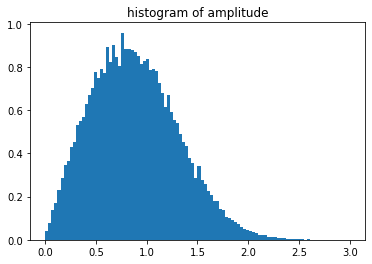

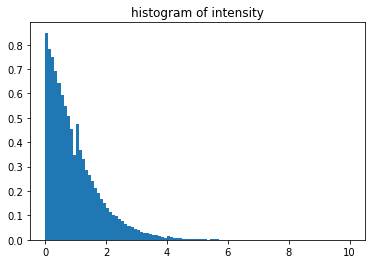

Im6
Mean
0.9548665886179611
Var
0.6239027695899474


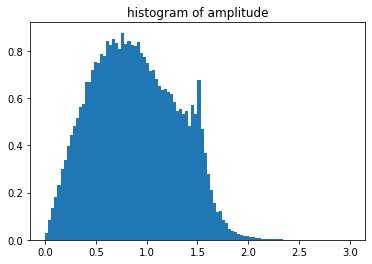

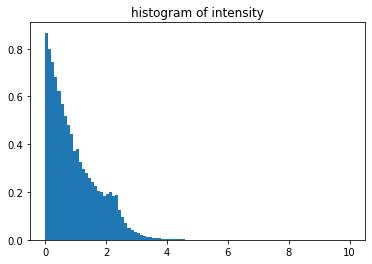

Examples with the oracle method 

Im0
Mean
1.0389591319823885
Var
1.051934421637907


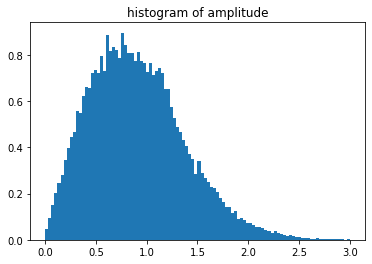

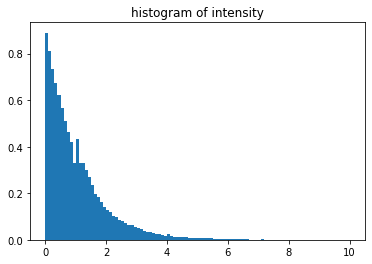

Im4
Mean
0.9834371038074248
Var
0.8234383353162414


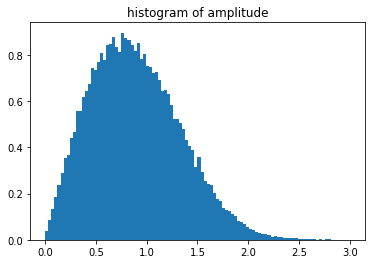

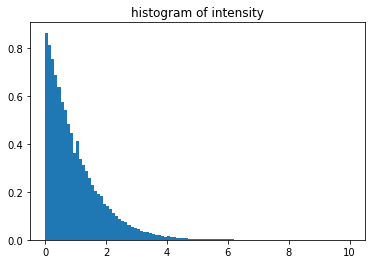

Im6
Mean
0.9632418347715722
Var
0.6538765444792953


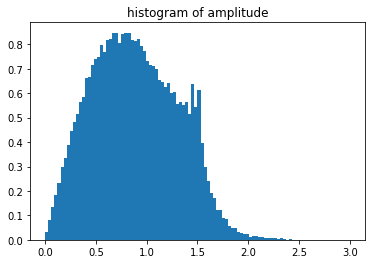

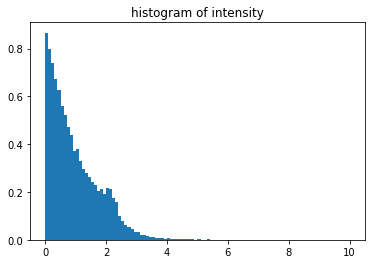

In [ ]:
print("Examples with the uniform noise map method \n")
for i in [1,3,5]:
  print("Im"+str(i))
  method_noise("loss_L1_view_L5",i)

print("Examples with the Local Means method \n")
for i in [2,3,6]:
  print("Im"+str(i))
  method_noise("loss_L1_view_L5_LM",i)

print("Examples with the oracle method \n")
for i in [0,4,6]:
  print("Im"+str(i))
  method_noise("loss_L1_view_L5",i)

## 3 - Application to real images

Now let's apply our models to Real images.

For these images, we have to adapt the value of the noise map compared to the previous section. Indeed, because of the characteristic of the real noise (correlation), the basic setting of FFDNet (no noise map) is not able to denoise the image per-se. Therefore, we have to add an additional smoothness with a non-null noise map. We see see here how powerful the noise map can be to remove artefacts.

To do so, **before running the cell open the file `main_test_ffdnet.py` and adapt the value of the noise map. A right value is 30 in line 66**.

For non-uniform noise map, you can also select a right noise map for the non-uniform methods but it requires more work on it by testing several values.

In [ ]:
# Get the set of real images (noisy images)
! rm -rf testsets
! mkdir testsets
! mkdir testsets/bsd68

for i,name_ld in enumerate(["lely_10",
                            "lely_11",
                            "marais1_10",
                            "marais1_11",
                            "marais2_10",
                            "marais2_11",
                            "limagne_10",
                            "limagne_20"]):
  img=np.load("FFDNet_data/Real_images/"+name_ld+".npy")
  name="testsets/bsd68/"+name_ld+".bmp"
  save_SAR(img,name=name)
save_SAR(np.load("data/saintgervais.npy"),name="testsets/bsd68/terrasar.jpg")


print("\n Denoised with the uniform noise map method \n")
# Denoising with uniform noise map
! python -m main_test_ffdnet


 Denoised with the uniform noise map method 

LogHandlers setup!
20-04-09 11:14:03.183 : Model path: model_zoo/loss_L1_view_L1.pth
20-04-09 11:14:03.183 : model_name:loss_L1_view_L1, model sigma:30, image sigma:30
20-04-09 11:14:03.183 : testsets/bsd68
20-04-09 11:14:03.648 : lely_10.bmp - PSNR: 16.48 dB; SSIM: 0.1637.
20-04-09 11:14:04.084 : lely_11.bmp - PSNR: 16.49 dB; SSIM: 0.1960.
20-04-09 11:14:05.190 : limagne_10.bmp - PSNR: 15.45 dB; SSIM: 0.1561.
20-04-09 11:14:06.267 : limagne_20.bmp - PSNR: 15.74 dB; SSIM: 0.1971.
20-04-09 11:14:07.344 : marais1_10.bmp - PSNR: 14.97 dB; SSIM: 0.1321.
20-04-09 11:14:08.418 : marais1_11.bmp - PSNR: 14.99 dB; SSIM: 0.1266.
20-04-09 11:14:09.499 : marais2_10.bmp - PSNR: 15.19 dB; SSIM: 0.1035.
20-04-09 11:14:10.577 : marais2_11.bmp - PSNR: 15.16 dB; SSIM: 0.0921.
20-04-09 11:14:10.682 : terrasar.jpg - PSNR: 20.69 dB; SSIM: 0.4202.
20-04-09 11:14:10.685 : Average PSNR/SSIM(RGB) - bsd68_loss_L1_view_L1 - PSNR: 16.13 dB; SSIM: 0.1764


Here are the results:


lely_10 

Noisy


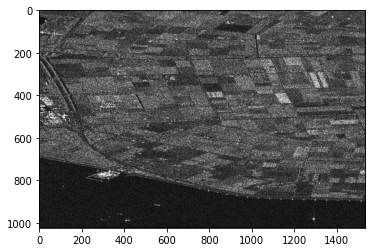

Denoised


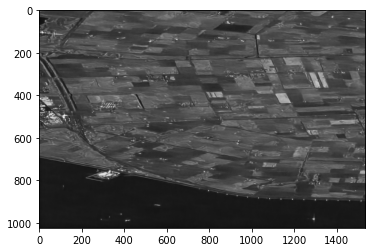


lely_11 

Noisy


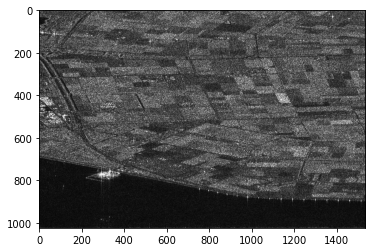

Denoised


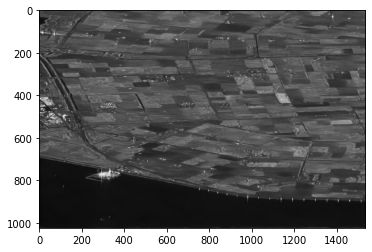


marais1_10 

Noisy


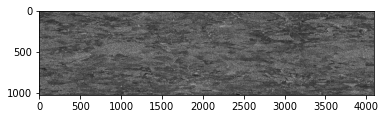

Denoised


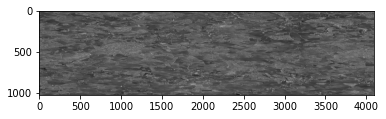


marais1_11 

Noisy


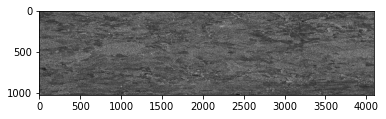

Denoised


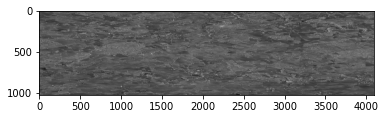


marais2_10 

Noisy


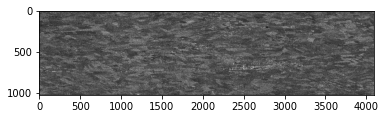

Denoised


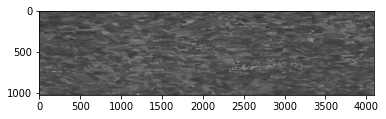


marais2_11 

Noisy


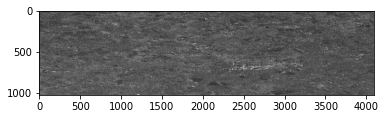

Denoised


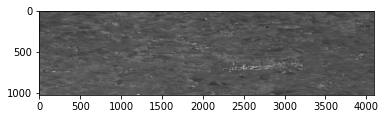


limagne_10 

Noisy


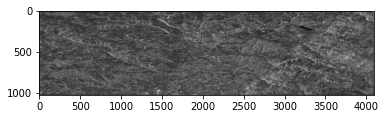

Denoised


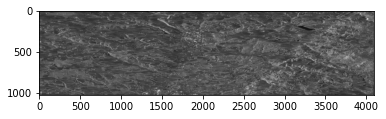


limagne_20 

Noisy


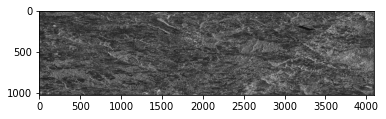

Denoised


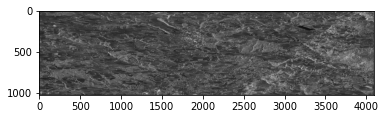


terrasar 

Noisy


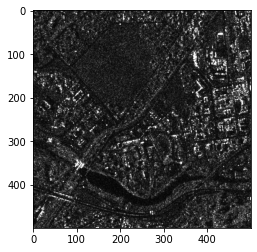

Denoised


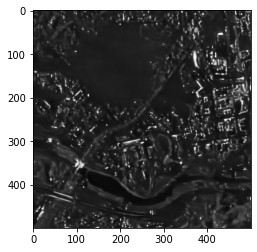

In [ ]:
for name_ld in ["lely_10","lely_11","marais1_10","marais1_11","marais2_10",
                "marais2_11","limagne_10","limagne_20","terrasar"]:
  plot_results(model_name="loss_L1_view_L1",real_name=name_ld)